In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import random
import colorsys
from PIL import Image

In [2]:
def load_image_as_np_array(filepath):
    # Open the image file
    img = Image.open(filepath)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    return img_array

def display_images(images, titles,max_img_per_row=3,vmin=0,vmax=255,conversion=cv2.COLOR_BGR2RGB):
   
    num_images = len(images)
    max_images_per_row = max_img_per_row
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Calculate number of rows needed
    
    # Create the subplots
    fig, axs = plt.subplots(num_rows, max_images_per_row, figsize=(15, 5 * num_rows))
    
    # Flatten the axs array in case of multiple rows
    axs = axs.flatten()
    
    for i in range(num_images):
        # disp_image = cv2.cvtColor(images[i].astype(np.uint8),conversion)
        axs[i].imshow(images[i],cmap='grey', vmin=vmin, vmax=vmax)
        axs[i].set_title(titles[i])
        axs[i].axis('off')  # Hide axes
    
    # Turn off remaining subplots if there are any
    for i in range(num_images, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
def scale(array, max = 255):
    min_val = np.min(array)
    max_val = np.max(array)
    
    if max_val == min_val:
        return np.zeros_like(array, dtype=np.uint8)  # Avoid division by zero
    
    scaled_array = (array - min_val) / (max_val - min_val) * max
    return scaled_array.astype(np.uint8)

## Image Loading

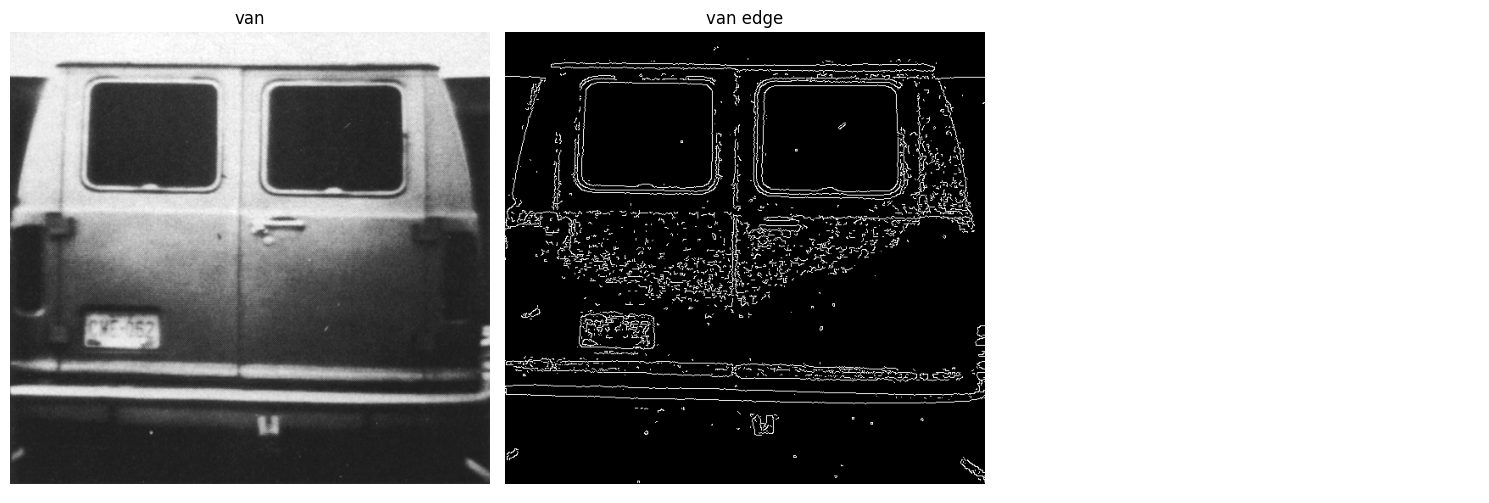

In [3]:
filepath = "DIP3E_Original_Images_CH10/van.tif"
van = load_image_as_np_array(filepath)

van_edge = cv2.Canny(van,70,100);

display_images([van,van_edge],["van","van edge"])

## Local Processing

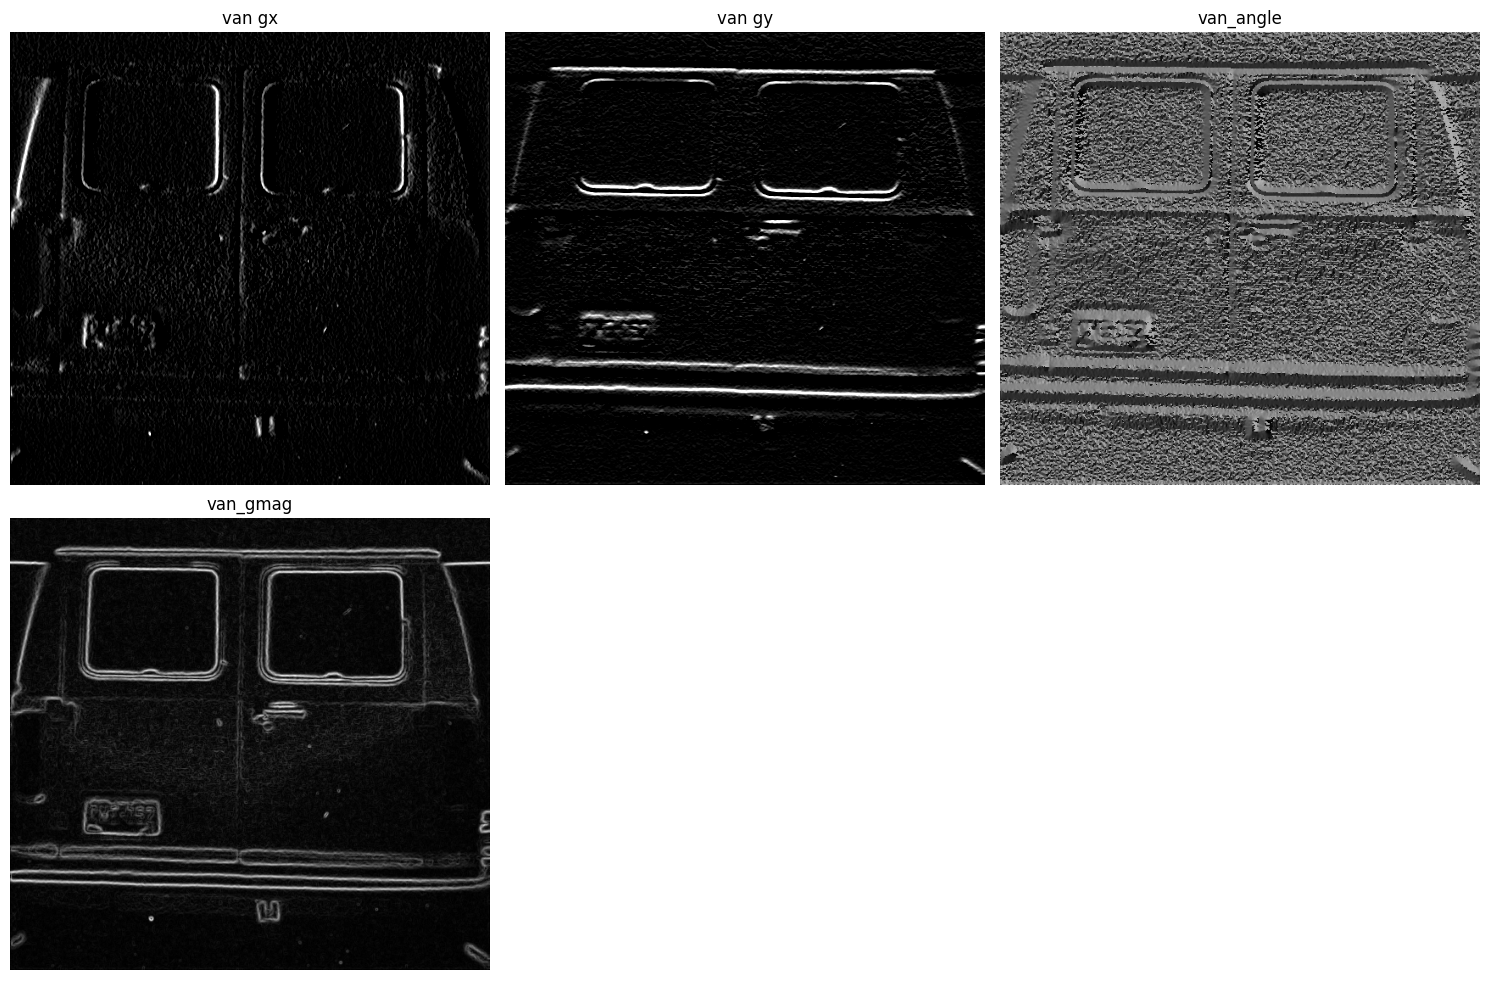

In [4]:
van_gx = cv2.Sobel(van,cv2.CV_64F,1,0,ksize=3)
van_gy = cv2.Sobel(van,cv2.CV_64F,0,1,ksize=3)


van_angle = scale(np.arctan2(van_gy,van_gx) , 180)
van_gmag = scale(np.sqrt(van_gx**2 + van_gy**2) )


display_images([van_gx,van_gy,van_angle,van_gmag],["van gx","van gy","van_angle","van_gmag"])

In [5]:
def getNeighbors(img, x, y):
    (w,h) = img.shape
    neighbors = []
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            if x+i >= 0 and x+i < w and y+j >= 0 and y+j < h:
                neighbors.append((x+i,y+j))
    return neighbors

C:\Users\samaz\AppData\Local\Temp\ipykernel_16260\3041714196.py:13: RuntimeWarning: overflow encountered in scalar subtract
  angle_dist = abs(van_angle[i,j] - van_angle[pi,pj])


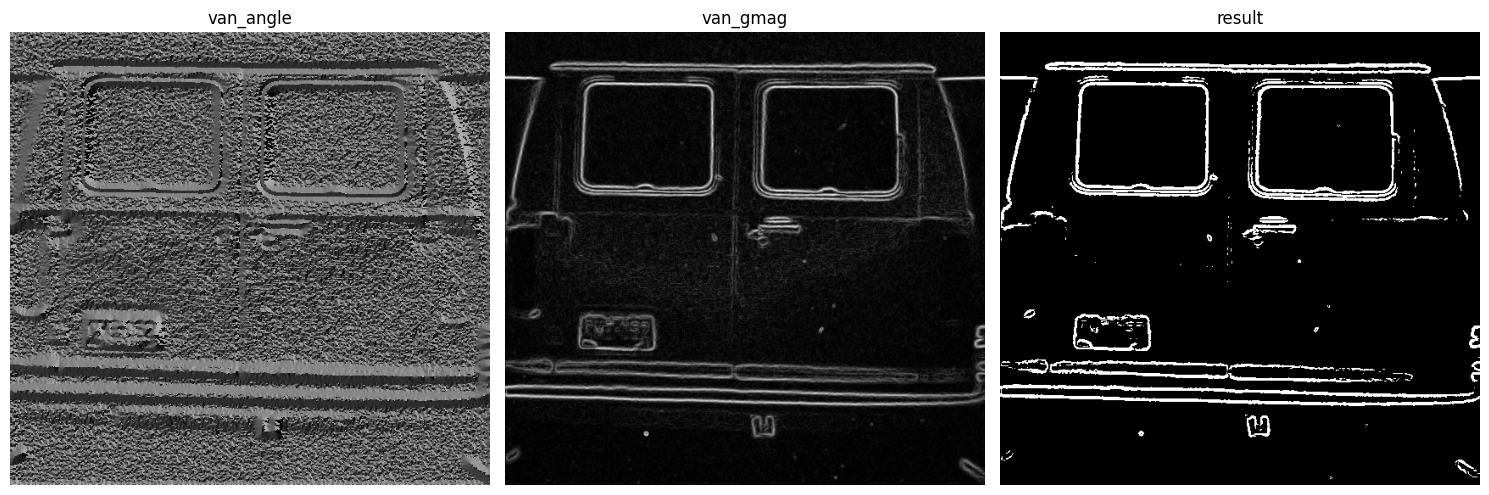

In [6]:
result = np.zeros(van_angle.shape)
angle_thresh = 40
grad_thresh = 70

for i in range(van_angle.shape[0]):
    for j in range(van_angle.shape[1]):
        neighbors = getNeighbors(van_angle,i,j)
        
        if van_gmag[i,j] > grad_thresh :
            for point in neighbors:
                ( pi , pj) = point
                if van_gmag[pi,pj] > grad_thresh:
                    angle_dist = abs(van_angle[i,j] - van_angle[pi,pj])
                    if angle_dist < angle_thresh:
                        result[i,j] = 255

display_images([van_angle,van_gmag,result],["van_angle","van_gmag","result"])
            
            

## Global Processing


In [7]:
def line_drawer(space,point):
    
    max_rho = space.shape[0] // 2   
    x,y = point
    theta = np.linspace(-np.pi/2, np.pi/2 , space.shape[0])
    
    rho = x * np.cos(theta) + y * np.sin(theta)
    
    for i in range(space.shape[0]):
        space[ int(rho[i]) + max_rho , i ] += 1
    return space , theta ,rho , max_rho

def line_drawer_img(img,ro, tht):
    
    w,h = img.shape
    res = np.zeros(img.shape)
    for x in range(w):
        y = ro - x*(1/np.tan(tht))
        
        if y >= 0 and y < h:
            res[x,int(y)] = 255
    return res

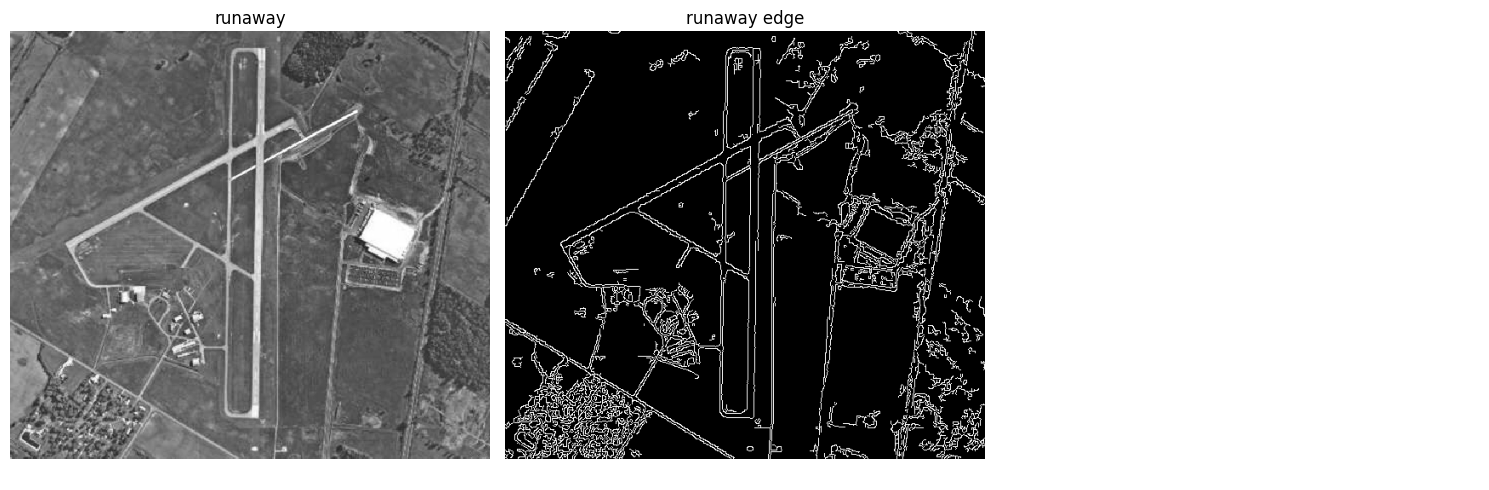

In [8]:
runaway = load_image_as_np_array("DIP3E_Original_Images_CH10/runaway.tif")

runaway_edge = cv2.Canny(runaway,100,280)


display_images([runaway,runaway_edge],["runaway","runaway edge"])


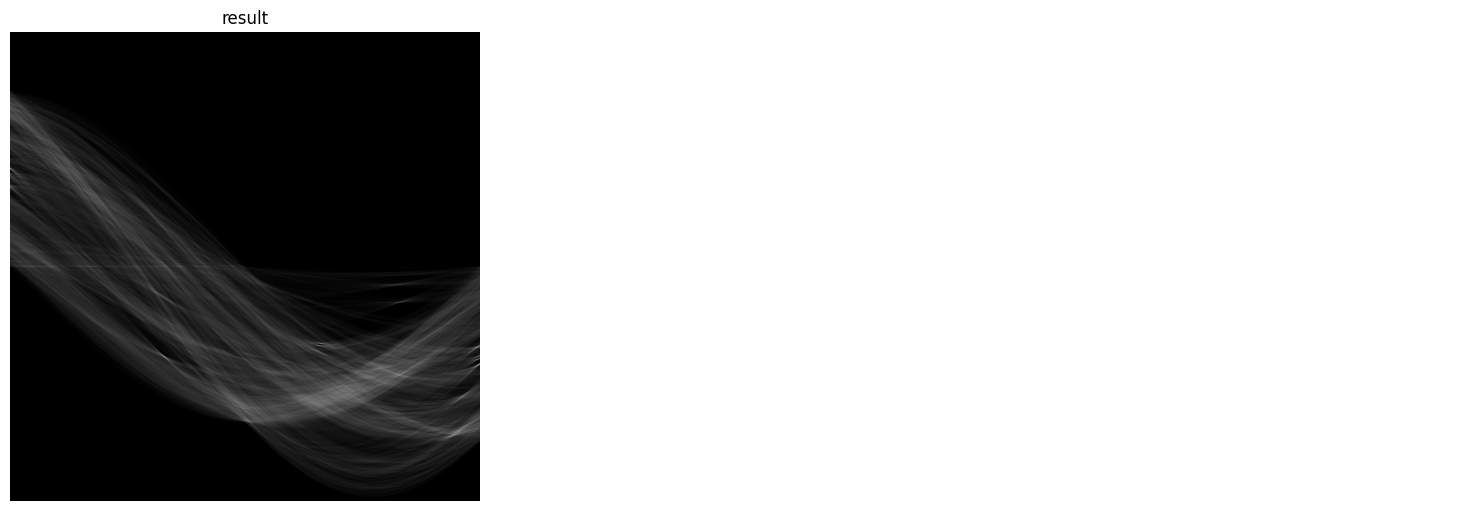

(286.0, (1069, 1507))

In [9]:
edge_thresh = 150

r,c = runaway_edge.shape

max_rho = int(np.sqrt(r**2 + c**2))
space = np.zeros(shape=(max_rho*2,max_rho*2))

theta=[]
rho = []

for i in range(runaway_edge.shape[0]):
    for j in range(runaway_edge.shape[1]):
        
        if runaway_edge[i,j] > edge_thresh:
           _ ,theta , rho ,_ =  line_drawer(space,(i,j))
            
            
            
display_images([space],["result"])

np.max(space),np.unravel_index(np.argmax(space),shape=space.shape)

286.0 (1069, 1507)
283.0 (1068, 1508)
277.0 (1045, 1502)


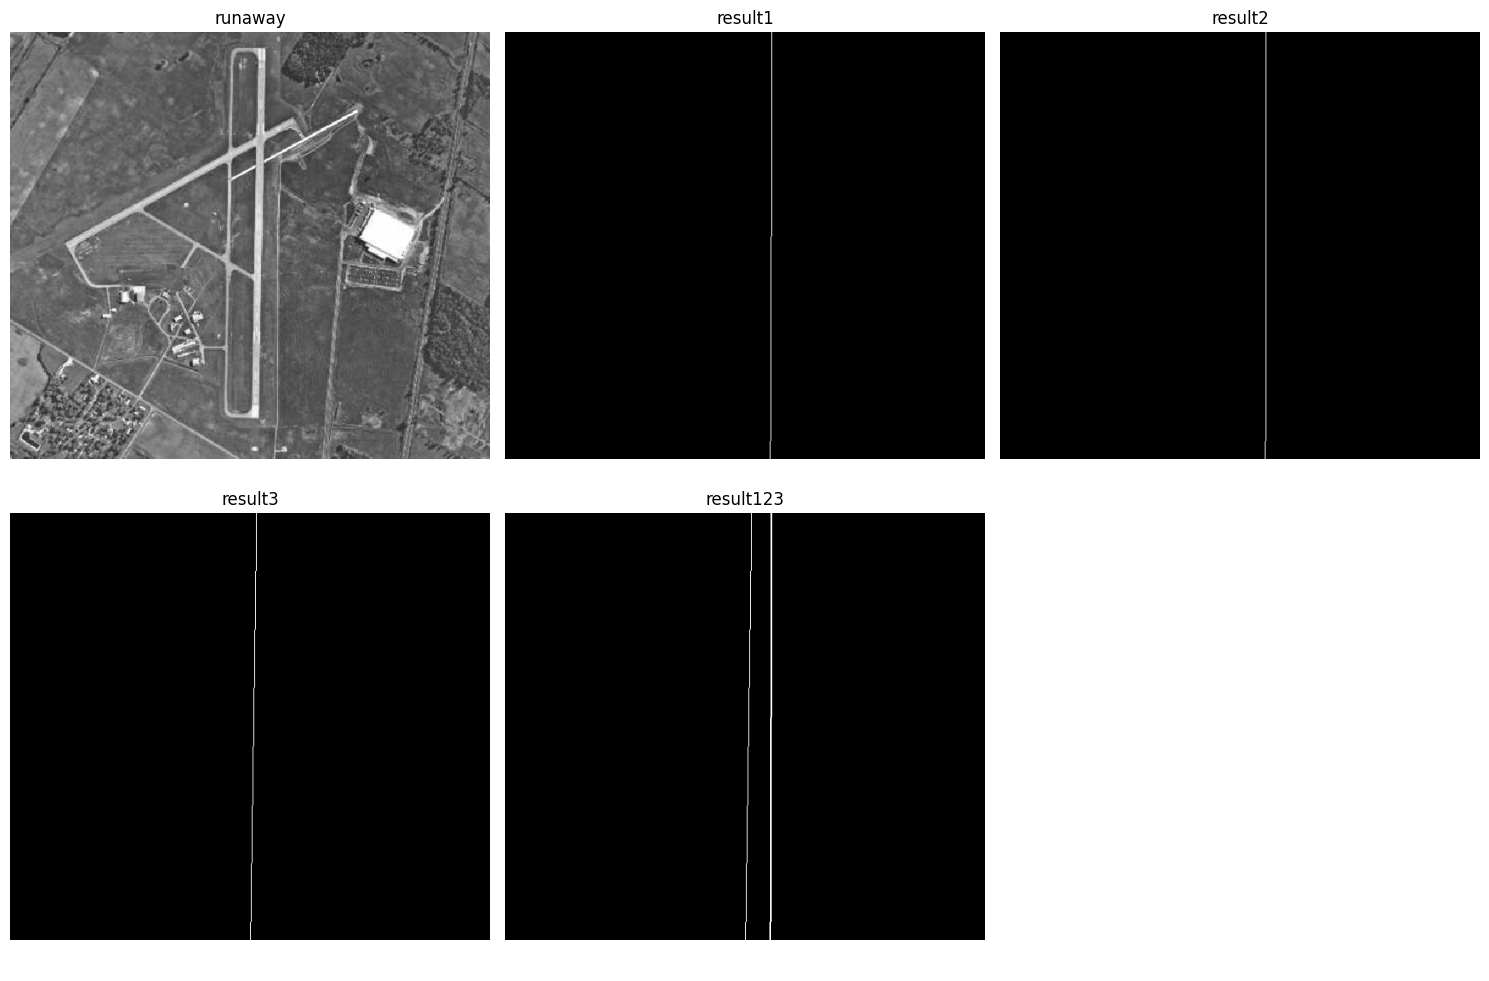

In [10]:
print(np.max(space),np.unravel_index(np.argmax(space),shape=space.shape))
index_r , index_t = np.unravel_index(np.argmax(space),shape=space.shape)
ro = index_r - max_rho
tht = theta[index_t]
result1 = line_drawer_img(runaway,ro,tht)
space[index_r,index_t]=0

print(np.max(space),np.unravel_index(np.argmax(space),shape=space.shape))
index_r , index_t = np.unravel_index(np.argmax(space),shape=space.shape)
ro = index_r - max_rho
tht = theta[index_t]
result2 = line_drawer_img(runaway,ro,tht)
space[index_r,index_t]=0

print(np.max(space),np.unravel_index(np.argmax(space),shape=space.shape))
index_r , index_t = np.unravel_index(np.argmax(space),shape=space.shape)
ro = index_r - max_rho
tht = theta[index_t]
result3 = line_drawer_img(runaway,ro,tht)
space[index_r,index_t]=0


display_images([runaway,result1,result2,result3 , result1+result2+result3],["runaway","result1","result2","result3","result123"])